In [1]:
from matplotlib import pyplot

from caffe2.python import brew, core, net_drawer, workspace
from caffe2.python.rnn_cell import RNNCell
from caffe2.python.model_helper import ModelHelper
from caffe2.python.utils import debug
from IPython import display
import numpy as np

# Initialize Caffe2, c++ logging, etc
workspace.GlobalInit(['caffe2', '--caffe2_log_level=2'])

In [2]:
class VanillaRNN(RNNCell):
    '''
    This class computes a "vanialla RNN". Which follows this formula:
    
    S_t = tanh(W * S_(t-1) + U * X_t + b)
    
    X_t is of input_size dimension and S_t is of hidden_size.
    Thus W is input_size x input_size and U is hidden_dim x input_size. b is a bias which is broadcasted. 
    
    This class demonstrates how it is easy to define an RNN using the formula above using Brew module and RNNCell
    class API. Then below we will show an example of how one can use this cell in their model.
    '''
    def __init__(self, input_size, output_size):
        super(VanillaRNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
    def apply_override(self, model, input_t, seq_lengths, states, timestep):
        '''
        This is the main part of the cell, here we define its structure.
        `seq_lengths` and `timestep` parameters are not required to be used by the cell operators.
        In more advanced usecases, operators in the cell can use them. Such as LSTMUnit uses them to figure out
        if output has to be masked out.
        
        `model` here is a ModelHelper object which represents the cell model, it is usually not the same model
        as the global one. Though in more complex scenarious caller can use this function on a global model,
        but we are not going to cover this in this tutorial.
        '''
        # We have just one state
        state,  = states
        
        # U * X_t part
        fc_input = brew.fc(model, input_t, blob_out='fc_input', dim_in=self.input_size, dim_out=self.output_size, axis=2)
        
        # W * S_(t-1) part. axis=2 because RecurrentOperator would provide a state of 1 x batch_size x output_size
        # First dimension 1 stands for a timestep dimension. As state in the cell point of view is just one piece
        # of the whole states sequence RNN is going to produce
        fc_state = brew.fc(model, state, blob_out='fc_state', dim_in=self.output_size, dim_out=self.output_size, axis=2)
        
        # Sum recurrent and input parts
        score = model.net.Sum([fc_input, fc_state], 'sum')
        
        # Add activation
        activation = model.net.Tanh(score, 'tanh')
        # Return a list of output states in the same order
        
        return [activation]

    def get_state_names(self):
        return ["state"]     

In [3]:
LENGTH=100
INPUT_SIZE=10
RNN_INPUT_SIZE=20
RNN_OUTPUT_SIZE=30
OUTPUT_SIZE=10

def construct_model():
    model = ModelHelper("my_rnn_model")
    # Add input projection to match RNN input size. axis=2 because input is (time x batch_size x rnn_input_size)
    rnn_input = brew.fc(model, 'input', 'rnn_input', dim_in=INPUT_SIZE, dim_out=RNN_INPUT_SIZE, axis=2)
    # Construct the cell, it is not used in our model yet
    cell = VanillaRNN(input_size=RNN_INPUT_SIZE, output_size=RNN_OUTPUT_SIZE)
    # Add RNN part
    all_states, _ = cell.apply_over_sequence(
        model, inputs=rnn_input, seq_lengths=None, initial_states=['init'])
    # all_states dims are (time x batch_size x rnn_output_size), so again axis=2
    output = brew.fc(model, all_states, 'output', dim_in=RNN_OUTPUT_SIZE, dim_out=OUTPUT_SIZE, axis=2)
    return model


In [4]:
model = construct_model()

In [5]:
# Make sure model runs
BATCH_SIZE = 2
input = np.random.randn(LENGTH, INPUT_SIZE).astype(np.float32)
workspace.blobs['input'] = np.random.randn(LENGTH, BATCH_SIZE, INPUT_SIZE).astype(np.float32)
workspace.blobs['init'] = np.zeros([BATCH_SIZE, RNN_OUTPUT_SIZE], dtype=np.float32)

workspace.RunNetOnce(model.param_init_net)
workspace.CreateNet(model.net, overwrite=True)
workspace.RunNet(model.net)

True

#### Model structure
In the cell below we can see how the model structure looks like. Everything defined within our cell is now collapsed as a RecurrentNetwork operator. 

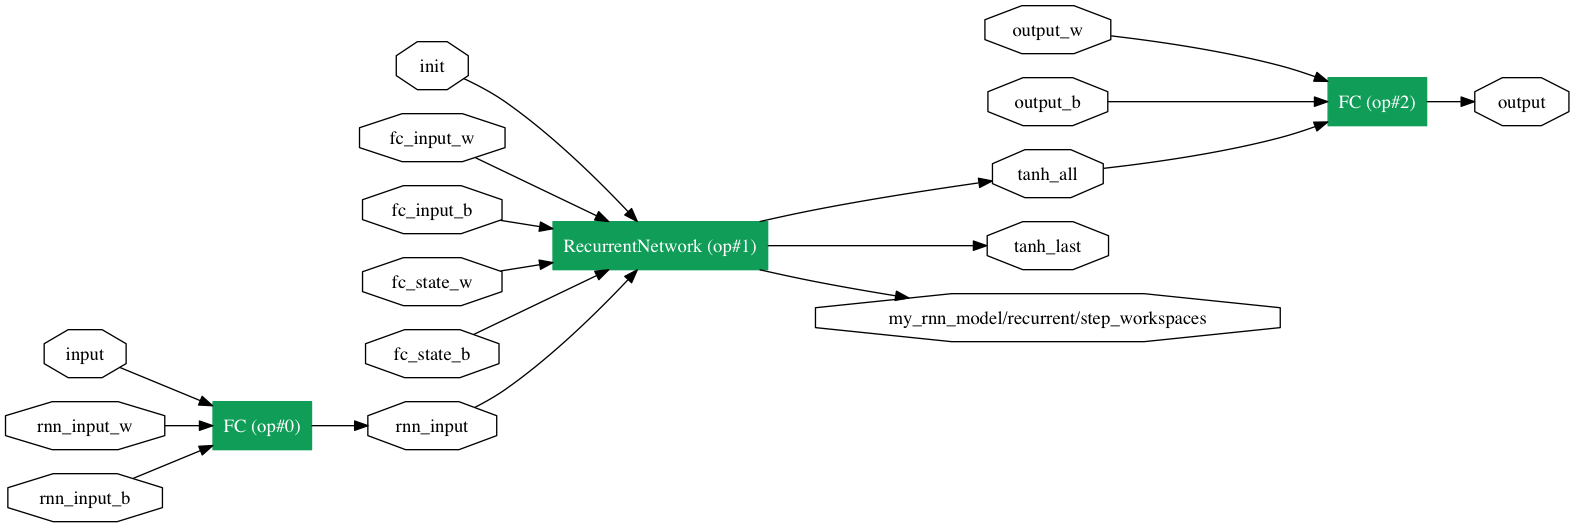

In [6]:
graph = net_drawer.GetPydotGraph(model.net.Proto().op, "RNN")
display.Image(graph.create_png(), width=1000)

#### Actual step net used in our model
You could also explore the step net created inside our model. This can be useful in debugging. 

You can see that input / output names of the step net don't match what we see as input / output of the RecurrentOperator in the main model. The reason for that is for each timestep there is a special container workspace created for running the step net. And inputs / output of the step net are linked into parts of real input / output blobs of the RecurrentNetwork operator. And those parts correspond to the current timestep.

In [7]:
def get_step_net_proto(model, rnn_op_idx=1):
    # Iterate over model's protobuf to extract argument containing step net's proto. '.n' here stands for a NetDef
    # Argument type. Please see proto/caffe2.proto for more details
    step_net_proto = [x for x in list(model.net.Proto().op[rnn_op_idx].arg) if x.name=='step_net'][0].n
    return step_net_proto

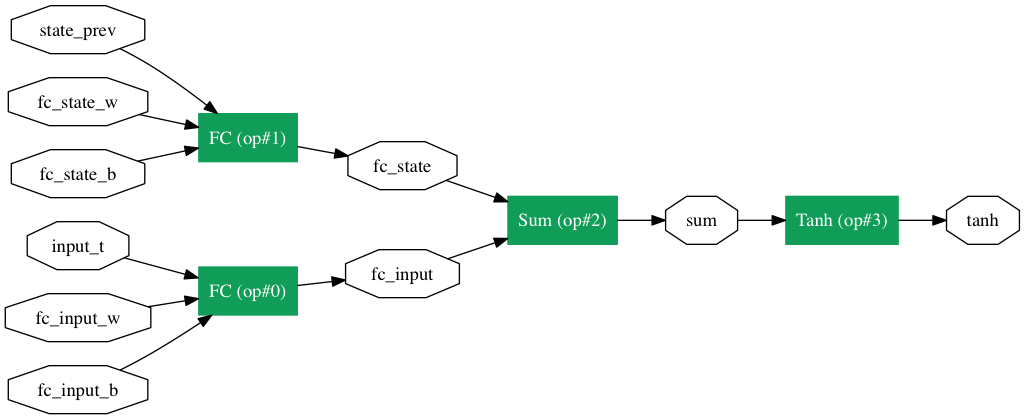

In [8]:
graph = net_drawer.GetPydotGraph(get_step_net_proto(model).op, "RNN")
display.Image(graph.create_png(), width=1000)

#### Stacking layers
Now lets learn how to use MultiRNNCell abstraction to stack layers. You can see below how you can access any layer states, not just the last one

In [9]:
from caffe2.python.rnn_cell import MultiRNNCell
# Input sizes for each of the layers and final output size
dims=[RNN_INPUT_SIZE, RNN_OUTPUT_SIZE * 2, RNN_OUTPUT_SIZE * 2, RNN_OUTPUT_SIZE]

cells = [VanillaRNN(dims[i], dims[i + 1]) for i in range(len(dims) - 1)]
# Combine all the cells
cell = MultiRNNCell(cells)
# These have to be available in the workspace when model runs
initial_states = ["init_{}".format(i) for i in range(len(dims) - 1)]
model = ModelHelper("stacked_rnn")
output, all_states = cell.apply_over_sequence(
    model,
    inputs='input',
    seq_lengths=None,
    initial_states=initial_states,
)
# Print name of the blob that is going to store final output - predictions for all time steps of the last layer
print(output)
# Blobs containing results for all the layers. Including all timesteps and final timesteps. Final timesteps are
# just views into the last element of a corresponding state blob for all timesteps
print(all_states)

layer_2/tanh_all
(BlobReference("layer_0/tanh_all"), BlobReference("layer_0/tanh_last"), BlobReference("layer_1/tanh_all"), BlobReference("layer_1/tanh_last"), BlobReference("layer_2/tanh_all"), BlobReference("layer_2/tanh_last"))


####  Graph view of the step network

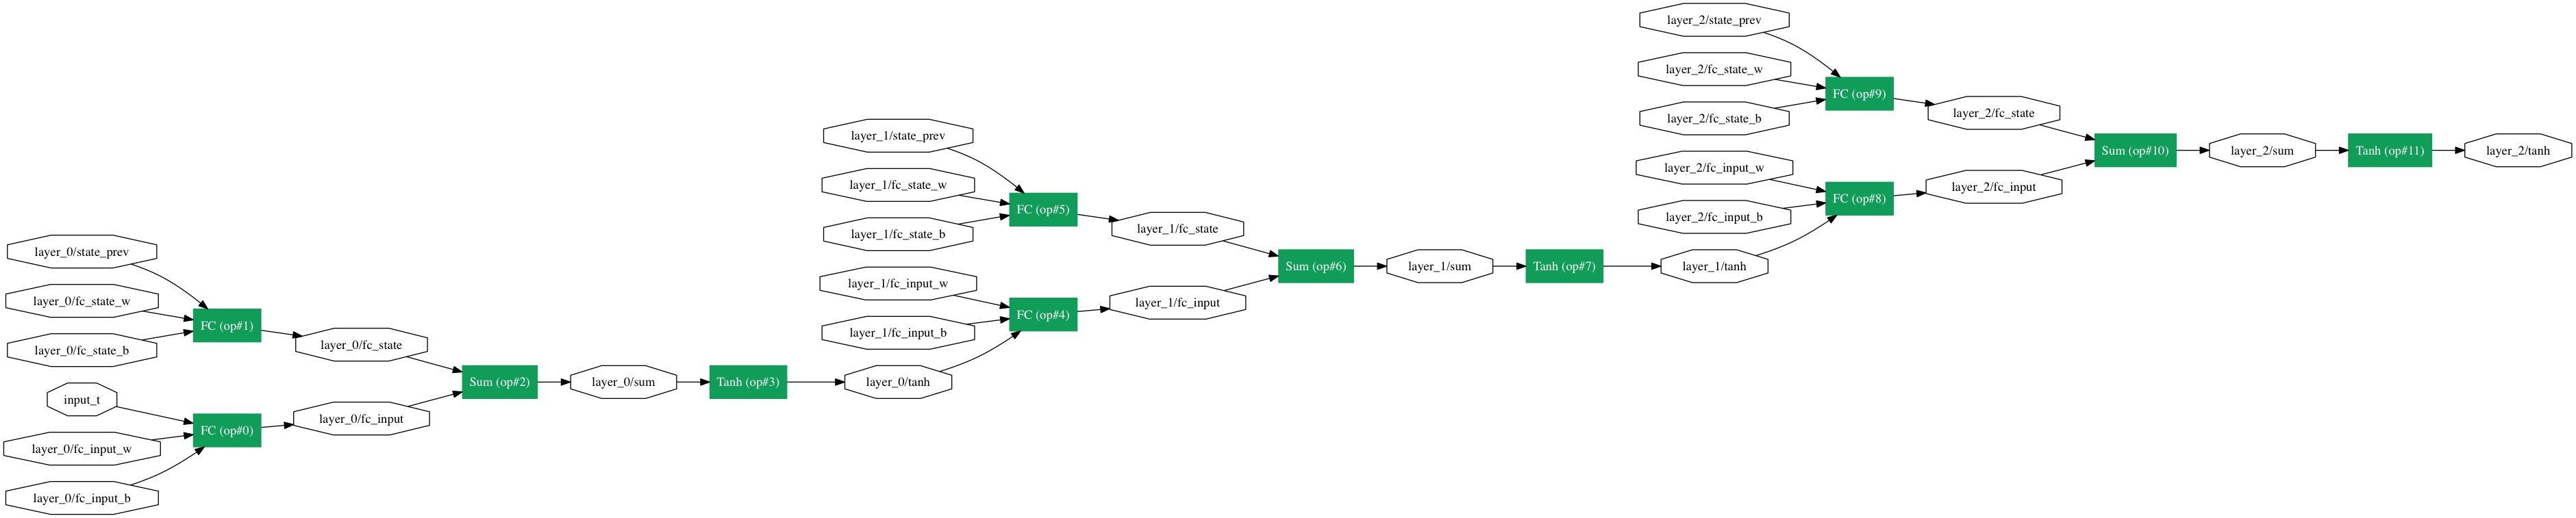

In [10]:
graph = net_drawer.GetPydotGraph(get_step_net_proto(model, 0).op, "RNN")
display.Image(graph.create_png(), width=1000)

####  Graph view of the main network
Now you could see how everything is just collapsed into a giant RecurrentNetwork operator. 

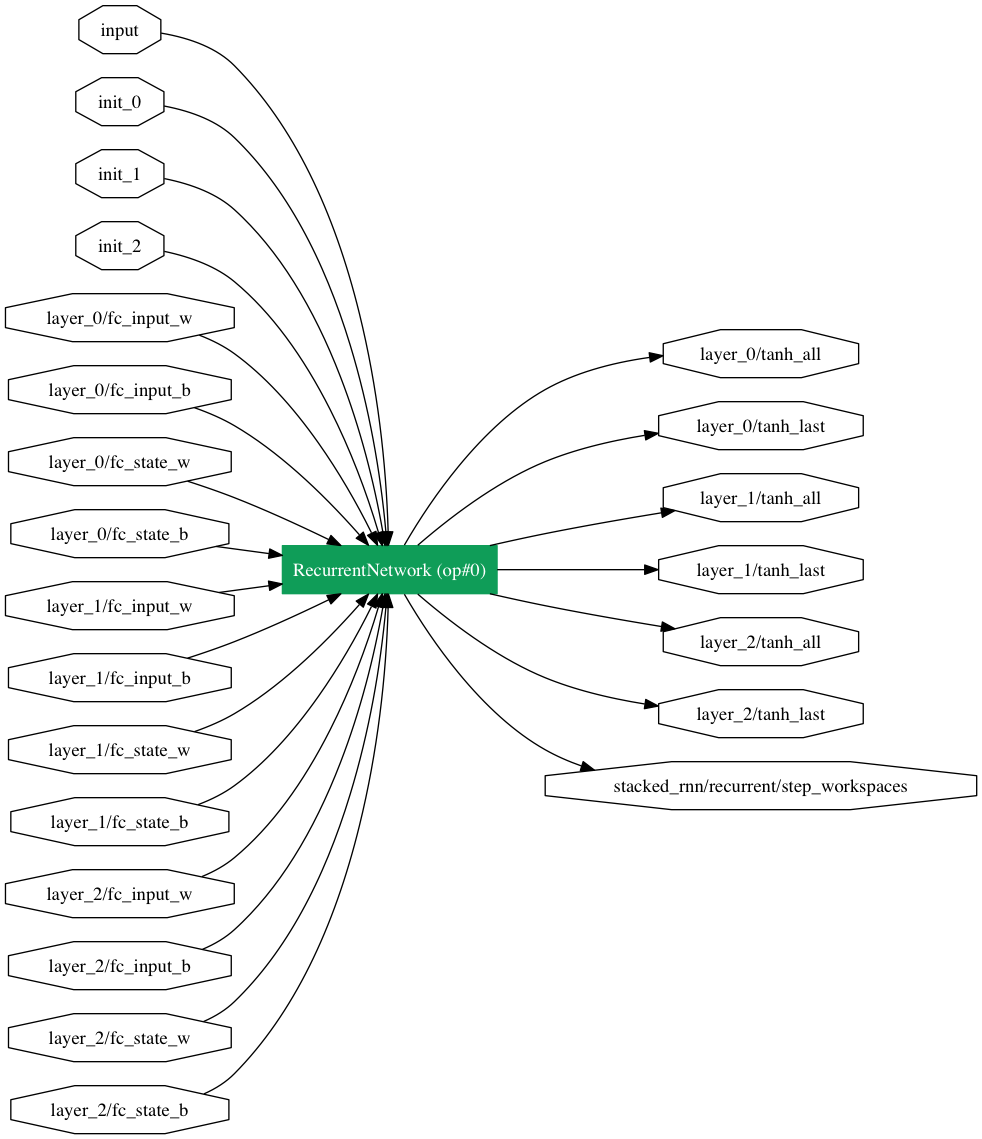

In [11]:
graph = net_drawer.GetPydotGraph(model.net.Proto().op, "RNN")
display.Image(graph.create_png(), width=1000)